## ML Models: SVM, RandomForests, XGBoost

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

### Load Datasets

In [5]:
train_df = pd.read_parquet("train_dataset.parquet")
test_df = pd.read_parquet("test_dataset.parquet")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
train_df.head()

Train shape: (37713, 26)
Test shape: (9429, 26)


,video_id,title,channelId,channelTitle,categoryId,tags,comments_disabled,ratings_disabled,description,likes_start,likes_end,view_count_start,view_count_end,comment_count_start,comment_count_end,trendingDuration,hoursToReachTrending,published_dayOfWeek,published_year,published_month,tagCount,engagement_rate,like_view_ratio,popularity_score,popularity_class,trend_cluster
0,lWVZOzSzhfE,Lil Tjay - Give You What You Want (Official Tr...,UCEB4a5o_6KfjxHwNMnmj54Q,Lil Tjay,Music,lil tjay|lil tjay new song|lil tjay new video|...,False,False,Lil Tjay Give You What You Want official video...,7596,8625,126556,159460,583,614,2,8.3,Thursday,2022,11,5,0.003850,0.054089,33.210523,1,0
1,wRwaVF-M0qo,Pranking My Sister with Bad Christmas Gifts (G...,UCuVHOs0H5hvAHGr8O4yIBNQ,Niki and Gabi,Howto & Style,niki and gabi|gift exchange|christmas gift exc...,False,False,Pranking My Sister with Bad Christmas Gifts (G...,10223,15767,158103,285080,316,404,9,24.0,Wednesday,2023,12,18,0.001417,0.055307,22.344142,1,1
2,BhC-QTs-kns,Amy Coney Barrett's Supreme Court confirmation...,UCXIJgqnII2ZOINSWNOGFThA,Fox News,News & Politics,Fox News|Judge Amy Coney Barrett|Trump SCOTUS|...,False,False,The Senate Judiciary Committee hearings for Su...,15081,15166,990042,998551,1263,1296,2,29.0,Thursday,2020,10,20,0.001298,0.015188,19.683658,1,1
3,Kq0M4_FDgT8,The Milwaukee Bucks Eliminate The Brooklyn Net...,UCU7iRrk3xfpUk0R6VdyC1Ow,NBA on TNT,Sports,NBA on TNT|NBA|Inside the NBA|Charles Barkley|...,False,False,The Inside crew reacts to Giannis and the Buck...,11726,12389,885580,958911,1952,1969,4,18.0,Sunday,2021,6,25,0.002053,0.012920,25.439213,1,1
4,gOA7M371Edg,Why Minecraft Removed These Controversial Spla...,UCHZ986wm_sJT6wntdDTIIcw,FitMC,Gaming,minecraft|history|update|mobs|creeper|raid|net...,False,False,Get exclusive NordVPN deal here ➵ https://nor...,23969,35337,354816,579895,2616,3670,4,10.2,Saturday,2022,7,63,0.006329,0.060937,223.638400,2,0


In [ ]:
target_col = 'popularity_class' 

y_train = train_df[target_col]
y_test = test_df[target_col]

# Encode target if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

### Feature Selection and Transformations

The following transformations are carried out:\
Categorical features (`categoryId`, `published_dayOfWeek`): One-Hot Encoding to represent each category as a binary vector. \
Numerical features (`published_month`, `tagCount`): StandardScaler to ensure consistent magnitude across features.\
Textual features (`title`, `channelTitle`, `tags`, `description`): Combined into a single text field and transformed into TF-IDF vectors. 


In [6]:
# Feature Transformation: text
train_df['text'] = (
    train_df['title'].fillna('') + ' ' +
    train_df['channelTitle'].fillna('') + ' ' +
    train_df['tags'].fillna('') + ' ' +
    train_df['description'].fillna('')
)
test_df['text'] = (
    test_df['title'].fillna('') + ' ' +
    test_df['channelTitle'].fillna('') + ' ' +
    test_df['tags'].fillna('') + ' ' +
    test_df['description'].fillna('')
)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(train_df['text'])
X_text_test = tfidf.transform(test_df['text'])  



# Feature Transformation: categories
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
X_cat = ohe.fit_transform(train_df[['categoryId', 'published_dayOfWeek']]) 
X_cat_test = ohe.transform(test_df[['categoryId', 'published_dayOfWeek']])

# Feature Transformation: scaling numeric variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num = scaler.fit_transform(train_df[['published_month', 'tagCount']])
X_num_test = scaler.transform(test_df[['published_month', 'tagCount']])

### SVC
A Support Vector Classifier with a linear kernel was trained on the transformed features.  SVMs are effective for high-dimensional data and can provide a useful point of comparison but they do not handle class imbalance well by default, hence no hyperparameter tuning was applied as this model was mainly intended to establish a reference.The model's performance was evaluated using a classification report, which provides metrics such as precision, recall, and F1-score for each class.

In [7]:
from scipy.sparse import hstack

X_train = hstack([X_text, X_cat, X_num])
X_test = hstack([X_text_test, X_cat_test, X_num_test])


In [8]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')  
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report

print("SVM Results:")
print(classification_report(y_test, y_pred))

SVM Results:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        34
         1.0       0.62      0.46      0.53      2302
         2.0       0.58      0.80      0.67      4774
         3.0       0.63      0.31      0.41      2319

    accuracy                           0.59      9429
   macro avg       0.46      0.39      0.40      9429
weighted avg       0.60      0.59      0.57      9429



The overall accuracy was 0.59, with a weighted F1-score of 0.57, indicating moderate performance.

### Random Forest
Random Forest was trained with `class_weight='balanced'` to address the class imbalance in the training data. We used 100 trees (`n_estimators=100`) for a good balance between performance and training speed for our datasets. We also set a fixed random seed for reproducibility.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced', 
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluate
print("Random Forest Results:")
print(classification_report(y_test, rf_preds))


Random Forest Results:
              precision    recall  f1-score   support

         0.0       0.62      0.15      0.24        34
         1.0       0.71      0.53      0.61      2302
         2.0       0.64      0.84      0.72      4774
         3.0       0.75      0.45      0.57      2319

    accuracy                           0.67      9429
   macro avg       0.68      0.49      0.53      9429
weighted avg       0.68      0.67      0.65      9429



The model achieved the highest accuracy (0.67) among the three tested. The macro average F1-score was 0.53, indicating that minority classes were not predicted as accurately.


### hyperparameter tuning - RF
We applied `GridSearchCV` to optimise hyperparameters for the Random Forest model. The grid included parameters like `n_estimators`, `max_features`, `max_depth`, and `class_weight`. The best configuration was selected based on the highest weighted F1-score from 5-fold cross-validation.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define the grid of parameters to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None],
    'max_depth': [None, 10, 20]
}

# Create the grid search object
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted', 
    n_jobs=-1,
    verbose=1
)

# Fit on the training data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


In [13]:
# Use the best parameters
best_rf = RandomForestClassifier(random_state=42, **grid_search.best_params_)
best_rf.fit(X_train, y_train)

# Predict
best_rf_preds = best_rf.predict(X_test)
print("Random Forest (Tuned) Results:")
print(classification_report(y_test, best_rf_preds))


Random Forest (Tuned) Results:
              precision    recall  f1-score   support

         0.0       0.62      0.15      0.24        34
         1.0       0.72      0.53      0.61      2302
         2.0       0.64      0.85      0.73      4774
         3.0       0.78      0.45      0.57      2319

    accuracy                           0.67      9429
   macro avg       0.69      0.49      0.54      9429
weighted avg       0.69      0.67      0.66      9429



The improvements from using the tuned parameters is not so significant as shown by the very similar evaluation metrics.

### XGBoost
We applied class balancing using `sample_weight`, based on class frequencies, to improve prediction for underrepresented classes. `n_estimators` is set to 100 to balance model complexity and training time. `max_depth` is set as 6 to provide enough capacity to capture non-linear patterns without overfitting. We choose a a conservative default learning rate of 0.1 that allows gradual learning. A fixed seed is also used for reproducibility.

In [10]:
!pip install xgboost

In [11]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

sample_weights = np.array([class_weight_dict[label] for label in y_train])

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, xgb_preds))


XGBoost Results:
              precision    recall  f1-score   support

         0.0       0.08      0.21      0.11        34
         1.0       0.56      0.69      0.62      2302
         2.0       0.70      0.47      0.56      4774
         3.0       0.49      0.69      0.57      2319

    accuracy                           0.58      9429
   macro avg       0.46      0.51      0.47      9429
weighted avg       0.61      0.58      0.58      9429



Its overall accuracy (0.58) was even lower than that of the baseline model, suggesting the need to find better configurations. We will proceed to perform hyperparameter tuning.

### hyperparameter tuning - XGBoost
Similar to the Rain Forest model, we used `GridSearchCV` to find the best set of parameters (`n_estimators`, `max_depth`, `learning_rate`)

In [14]:
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(
    XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_train)),
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train, sample_weight=sample_weights)  # pass your weighted samples here

print("Best Parameters:", grid_search.best_params_)

# Retrain using best parameters
best_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    **grid_search.best_params_
)
best_xgb.fit(X_train, y_train, sample_weight=sample_weights)

# Predict
best_xgb_preds = best_xgb.predict(X_test)
print("XGBoost (Tuned) Results:")
print(classification_report(y_test, best_xgb_preds))


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [21:21:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
XGBoost (Tuned) Results:
              precision    recall  f1-score   support

         0.0       0.55      0.18      0.27        34
         1.0       0.59      0.72      0.65      2302
         2.0       0.70      0.57      0.63      4774
         3.0       0.56      0.66      0.61      2319

    accuracy                           0.63      9429
   macro avg       0.60      0.53      0.54      9429
weighted avg       0.64      0.63      0.63      9429



The results improved significantly using the best set of parameters, although it is still slightly lower than that of the Rain Forest model.

### Evaluation - Confusion Matrix
We proceed to evalute the models further with confusion matrix to understand how balanced is their predicive power.

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, cmap='Blues', values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()

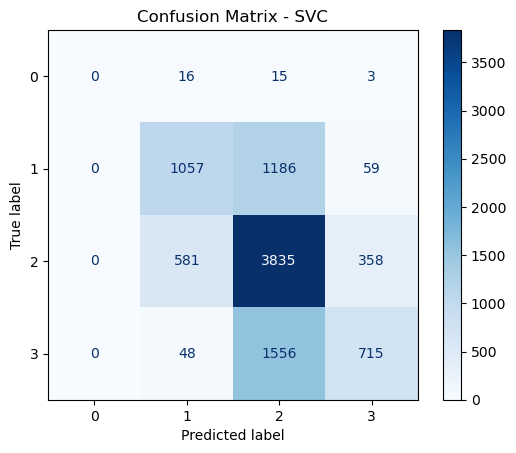

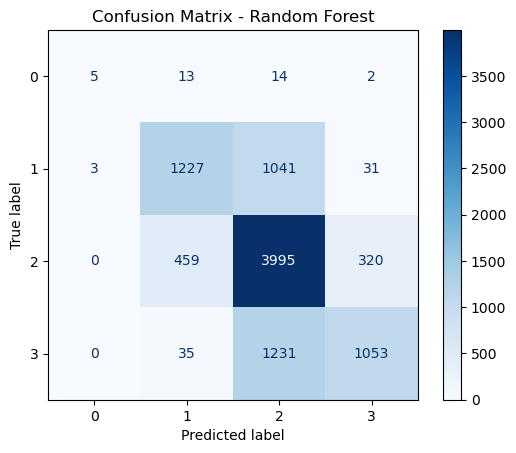

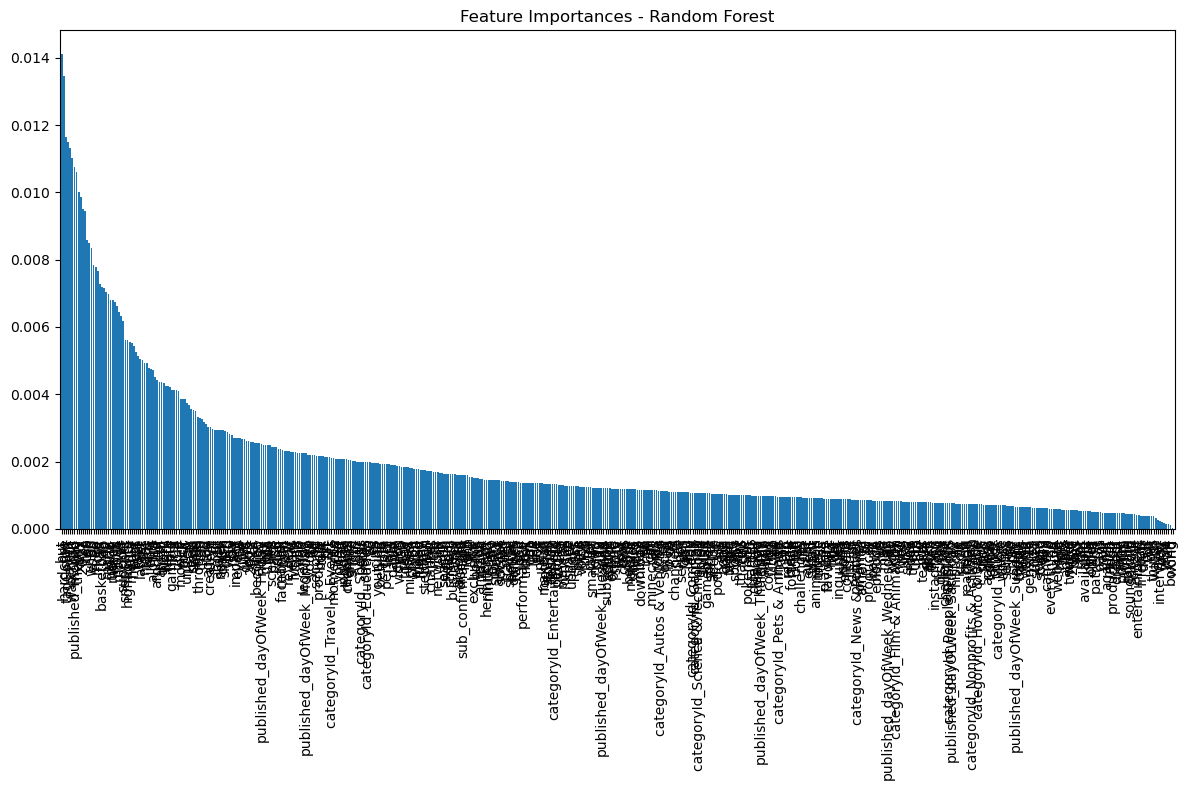

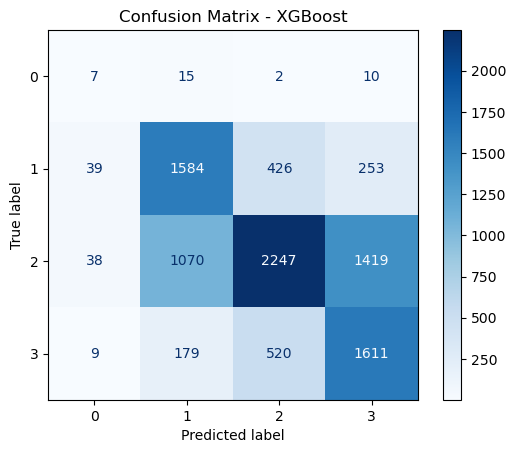

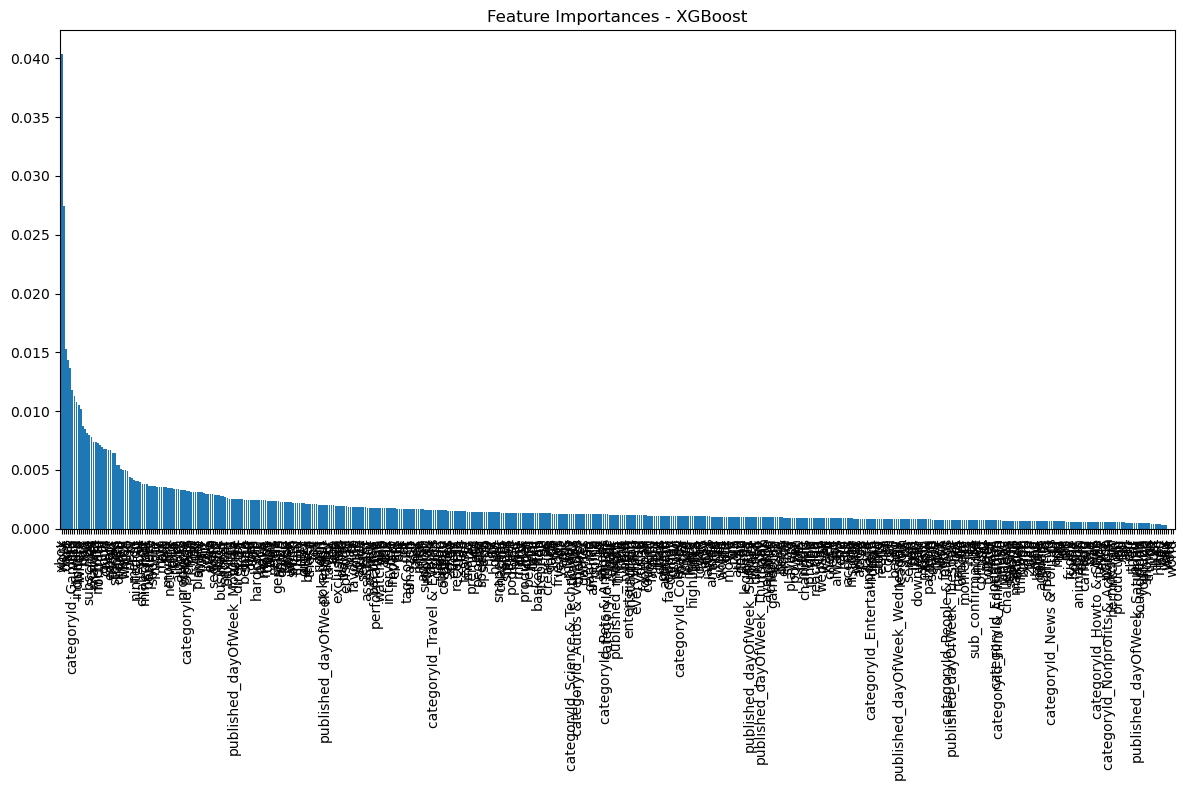

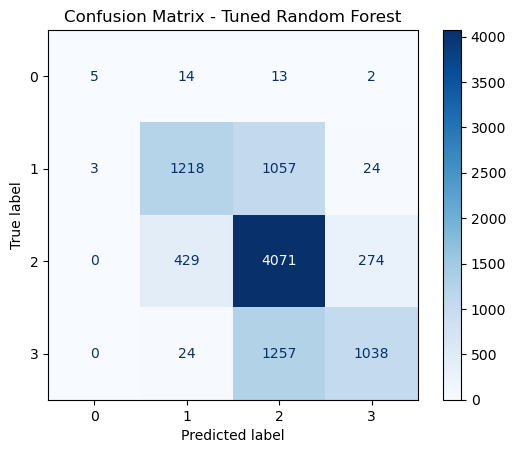

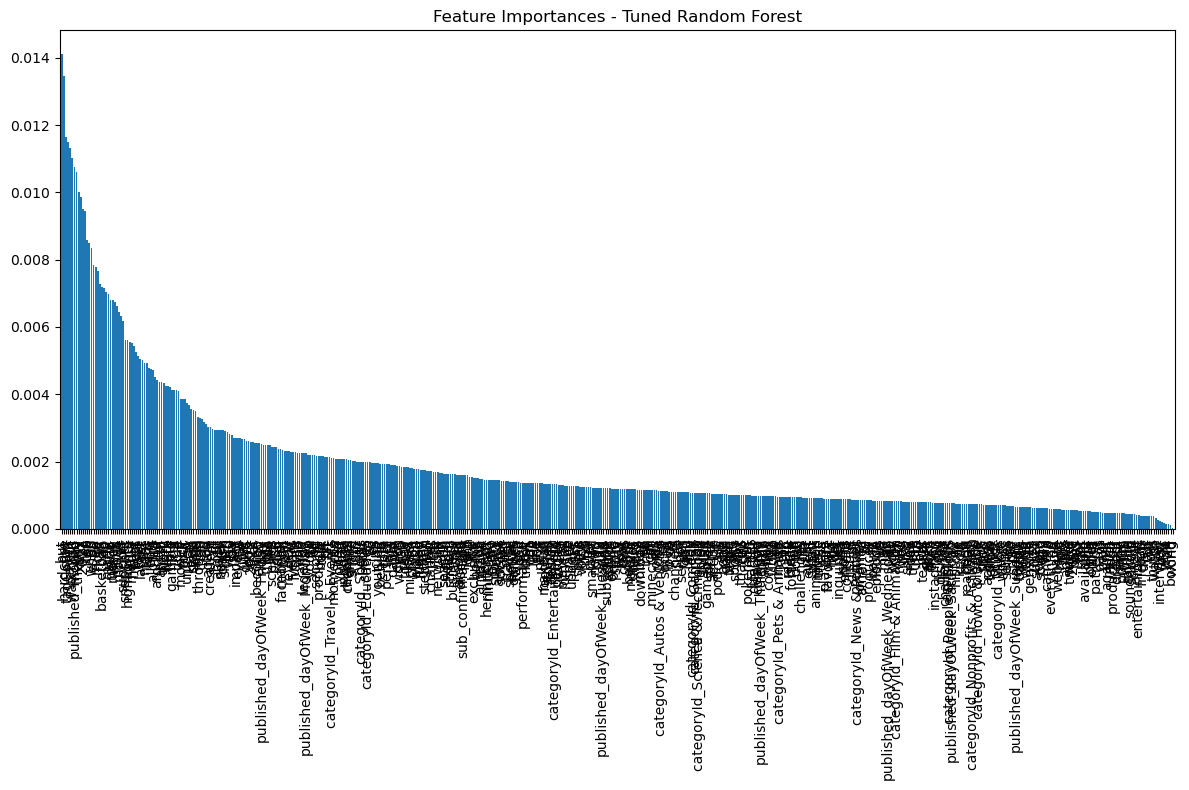

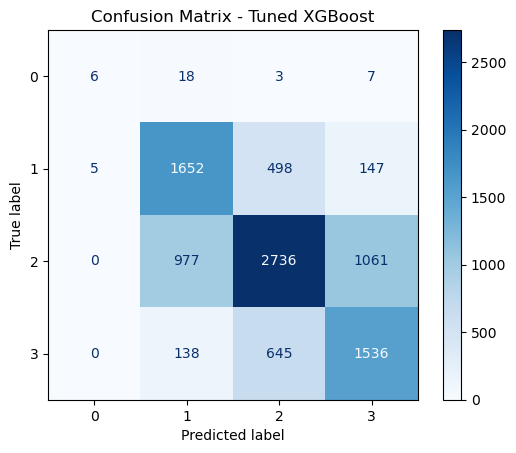

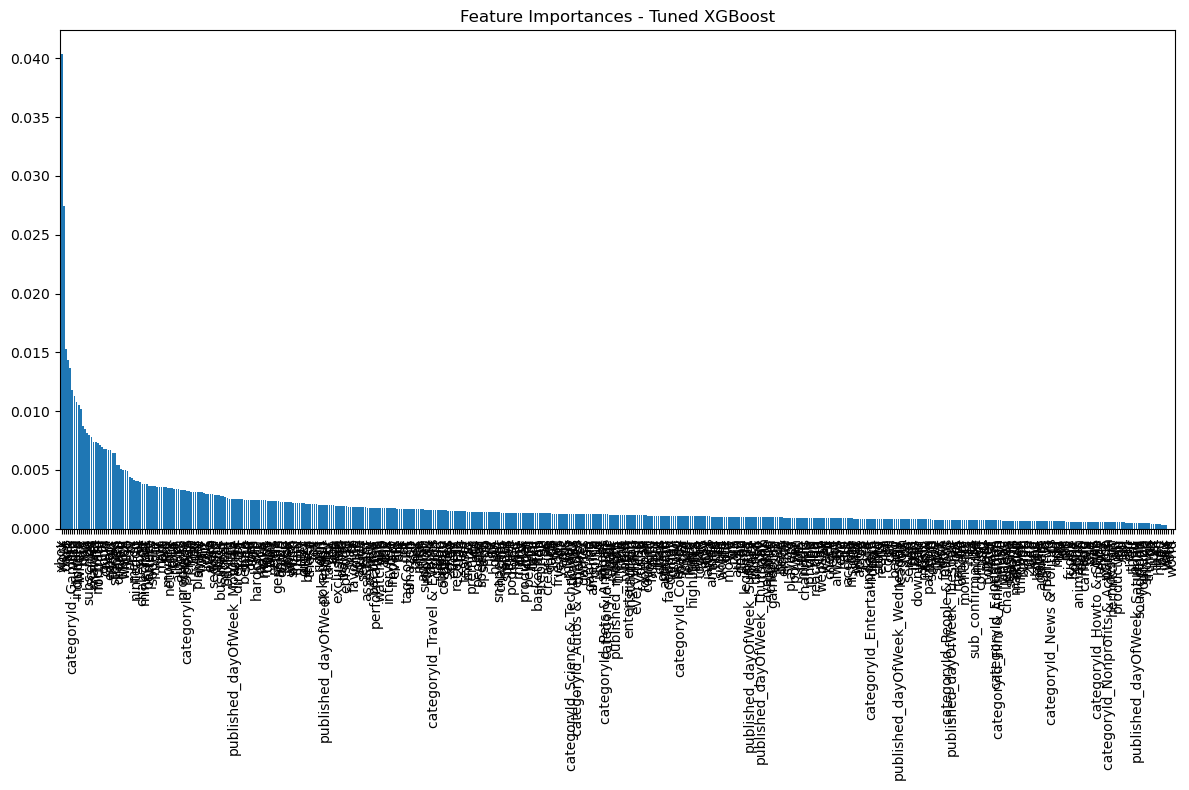

In [17]:
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix - SVC")

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf_preds, title="Confusion Matrix - Random Forest")
# Feature Importance for Random Forest
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(ohe.get_feature_names_out()).tolist() + tfidf.get_feature_names_out().tolist() + ['published_month', 'tagCount']
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# Plot confusion matrix for XGBoost
plot_confusion_matrix(y_test, xgb_preds, title="Confusion Matrix - XGBoost")
# Feature Importance for XGBoost
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - XGBoost")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

# Plot confusion matrix for tuned Random Forest
plot_confusion_matrix(y_test, best_rf_preds,
                      title="Confusion Matrix - Tuned Random Forest")
# Feature Importance for Tuned Random Forest
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - Tuned Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()


# Plot confusion matrix for tuned XGBoost
plot_confusion_matrix(y_test, best_xgb_preds,
                      title="Confusion Matrix - Tuned XGBoost")
# Feature Importance for Tuned XGBoost
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances - Tuned XGBoost")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(
    feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

The confusion matrices highlight how well each model distinguishes between the four popularity classes:\
\
SVM struggled with minority classes (0 and 3), heavily favouring class 2 predictions. Its confusion matrix revealed a strong bias towards the majority class, confirming its limitations in imbalanced multi-class settings.\
\
Random Forest performed well on class 2 but continued to underperform on class 3, despite class weighting. This suggests that the model, while accurate overall, is less reliable for less frequent classes.\
\
XGBoost achieved a more even distribution of correct predictions across classes, with better recall for class 1 and 3 compared to other models. This reflects its ability to balance precision and recall across imbalanced datasets.\
\
Tuned models, especially XGBoost, showed further improvements in minority class prediction, with fewer misclassifications across class boundaries. This balance is critical in real-world applications where all classes matter.

Overall, the model evaluations confirm that while Random Forest delivers strong baseline performance, XGBoost (tuned) offers the best balance across classes and better interpretability via feature importance. 
